In [14]:
import os
import pandas as pd
import numpy as np
import random
import joblib
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    CategoricalNB,
    ComplementNB,
    BernoulliNB,
)
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

from sklearn.experimental import enable_halving_search_cv  # Enable the HalvingGridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold, HalvingRandomSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, matthews_corrcoef, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import logging
#from sb_project.NeuralNetworks import *


In [15]:
random.seed(42)

In [16]:
path_to_data= Path("../data")

df_complete = pd.read_csv(path_to_data / "df_complete.csv")
df_complete.head

<bound method NDFrame.head of          Unnamed: 0 pdb_id s_ch  s_resi s_ins s_resn s_ss8  s_rsa  s_up  \
0                 0   1u9c    A      32            Y     H  0.149  22.0   
1                 1   1u9c    A     112            L     H  0.000  25.0   
2                 2   1u9c    A     107            T     H  0.162  11.0   
3                 3   1u9c    A     147            K     -  0.190  18.0   
4                 4   1u9c    A     109            Q     H  0.263  13.0   
...             ...    ...  ...     ...   ...    ...   ...    ...   ...   
2477051        1032   3vrd    B     231            D     E  0.466   9.0   
2477052        1033   3vrd    A      44            F     H  0.162  18.0   
2477053        1034   3vrd    A      13            G     H  0.000  16.0   
2477054        1035   3vrd    A     163            L     H  0.024  13.0   
2477055        1036   3vrd    B      22            K     H  0.146  17.0   

         s_down  ...  t_down  t_phi  t_psi  t_ss3   t_a1   t_a2   t_a

In [17]:
# Remove all rows with NaN in at least one column
# including rows with missing class (they could be false negatives)
df_complete.dropna(inplace=True)

# Define ground truth values
y = df_complete["Interaction"].astype("category")
y

1          HBOND
3          HBOND
6          HBOND
7            VDW
9          HBOND
           ...  
2477049    HBOND
2477050      VDW
2477051    HBOND
2477052    HBOND
2477054      VDW
Name: Interaction, Length: 1471380, dtype: category
Categories (7, object): ['HBOND', 'IONIC', 'PICATION', 'PIHBOND', 'PIPISTACK', 'SSBOND', 'VDW']

In [18]:
new_df = pd.DataFrame(df_complete.iloc[:1000000, :])
new_df.dropna(inplace=True)

# Esplora il dataset per vedere quali colonne sono disponibili
print(new_df.columns)

Index(['Unnamed: 0', 'pdb_id', 's_ch', 's_resi', 's_ins', 's_resn', 's_ss8',
       's_rsa', 's_up', 's_down', 's_phi', 's_psi', 's_ss3', 's_a1', 's_a2',
       's_a3', 's_a4', 's_a5', 't_ch', 't_resi', 't_ins', 't_resn', 't_ss8',
       't_rsa', 't_up', 't_down', 't_phi', 't_psi', 't_ss3', 't_a1', 't_a2',
       't_a3', 't_a4', 't_a5', 'Interaction'],
      dtype='object')


In [19]:
y = new_df["Interaction"].astype("category")
# Define training features
X = new_df[
    [
        "s_ss8",
        "s_ss3",
        "s_rsa",
        "s_up",
        "s_down",
        "s_phi",
        "s_psi",
        "s_a1",
        "s_a2",
        "s_a3",
        "s_a4",
        "s_a5",
        "t_ss8",
        "t_ss3",
        "t_rsa",
        "t_up",
        "t_down",
        "t_phi",
        "t_psi",
        "t_a1",
        "t_a2",
        "t_a3",
        "t_a4",
        "t_a5",
    ]
]

# Calculate percentiles and transform into categories
X = X.rank(pct=True).round(1).astype("category")

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset to define training and testing examples
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [20]:
bonds = ["HBOND", "IONIC", "PICATION", "PIHBOND", "PIPISTACK", "SSBOND", "VDW"]

for bond in bonds:
    print(f"this is new_df {bond}: {len(new_df[new_df["Interaction"] == bond])}")
    print(f"this is df {bond}: {len(df_complete[df_complete["Interaction"] == bond])}\n")

this is new_df HBOND: 557203
this is dfHBOND: 820333

this is new_df IONIC: 18494
this is dfIONIC: 27538

this is new_df PICATION: 4583
this is dfPICATION: 6874

this is new_df PIHBOND: 1127
this is dfPIHBOND: 1669

this is new_df PIPISTACK: 20447
this is dfPIPISTACK: 30117

this is new_df SSBOND: 1126
this is dfSSBOND: 1657

this is new_df VDW: 397020
this is dfVDW: 583192



# Logistic Regression

In [21]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42))
])

# Define the hyperparameter grid
param_dist = {
    'logreg__C': uniform(loc=0.1, scale=5),  # Reduce the range of C values
    'logreg__solver': ['liblinear'],
    'logreg__penalty': ['l2'],  # Use only one penalty
    'logreg__max_iter': [100]  # Use only one value for max_iter
}

# Define the cross-validation strategy
cv_strategy = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)  # Use fewer folds

# Perform hyperparameter search with HalvingRandomSearchCV
random_search = HalvingRandomSearchCV(
    pipeline, 
    param_distributions=param_dist, 
    n_candidates=30,  # Limit the number of candidates
    factor=3,
    resource='n_samples',
    max_resources='auto',
    min_resources=50,  # Increase min_resources to start with more samples
    cv=cv_strategy, 
    scoring='accuracy', 
    verbose=1, 
    n_jobs=-1, 
    random_state=42
)

# Fit the model
random_search.fit(X_new_train, y_new_train)

# Best model
best_logreg = random_search.best_estimator_

# Results
print(f"Best score: {random_search.best_score_}")
print(f"Best parameters: {random_search.best_params_}")

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 9
min_resources_: 50
max_resources_: 800000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 30
n_resources: 50
Fitting 2 folds for each of 30 candidates, totalling 60 fits
----------
iter: 1
n_candidates: 10
n_resources: 150
Fitting 2 folds for each of 10 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 4
n_resources: 450
Fitting 2 folds for each of 4 candidates, totalling 8 fits
----------
iter: 3
n_candidates: 2
n_resources: 1350
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Best score: 0.5377777777777777
Best parameters: {'logreg__C': 3.1592644736118976, 'logreg__max_iter': 100, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}


In [22]:
# Cross-validation con meno fold
cv = StratifiedKFold(n_splits=3)  # Ridurre il numero di fold
cv_scores = cross_val_score(best_logreg, X_new_train, y_new_train, cv=cv, scoring='accuracy', n_jobs=-1)  # Parallelizzare

print(f'Cross-validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}')

# Predire sul set di test
y_new_pred = best_logreg.predict(X_new_test)

# Metriche di valutazione
accuracy = accuracy_score(y_new_test, y_new_pred)
mcc = matthews_corrcoef(y_new_test, y_new_pred)
balanced_acc = balanced_accuracy_score(y_new_test, y_new_pred)
roc_auc = roc_auc_score(pd.get_dummies(y_new_test), pd.get_dummies(y_new_pred), multi_class='ovo')

print(f'Accuracy: {accuracy:.2f}')
print(f'Matthews Correlation Coefficient: {mcc:.2f}')
print(f'Balanced Accuracy: {balanced_acc:.2f}')
print(f'ROC-AUC: {roc_auc:.2f}')

print('Classification Report:')
print(classification_report(y_new_test, y_new_pred))

Cross-validation Accuracy: 0.57 ± 0.00
Accuracy: 0.57
Matthews Correlation Coefficient: 0.10
Balanced Accuracy: 0.27
ROC-AUC: 0.54
Classification Report:


c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       HBOND       0.57      0.96      0.72    111441
       IONIC       0.40      0.00      0.00      3699
    PICATION       0.00      0.00      0.00       917
     PIHBOND       0.00      0.00      0.00       225
   PIPISTACK       0.41      0.27      0.32      4089
      SSBOND       0.54      0.61      0.57       225
         VDW       0.47      0.07      0.11     79404

    accuracy                           0.57    200000
   macro avg       0.34      0.27      0.25    200000
weighted avg       0.52      0.57      0.45    200000



c:\Users\emmal\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


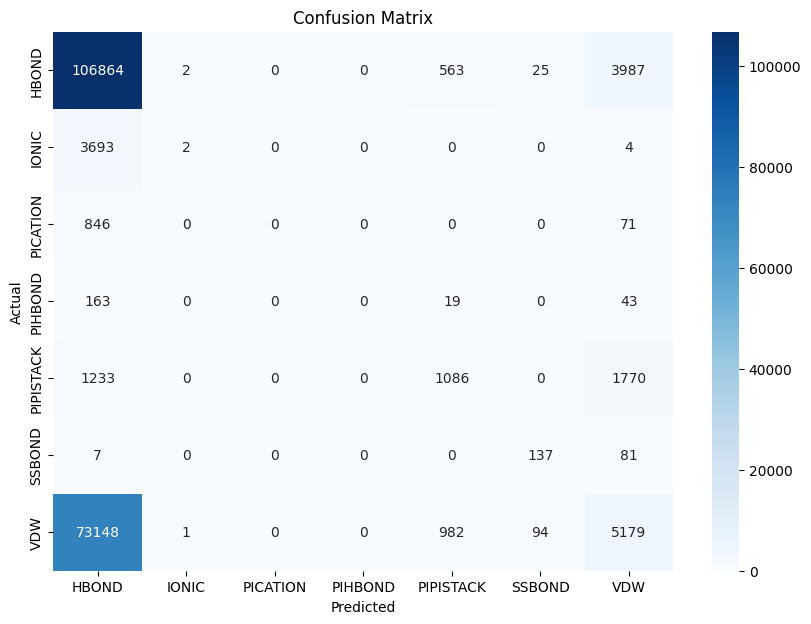

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_new_test, y_new_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

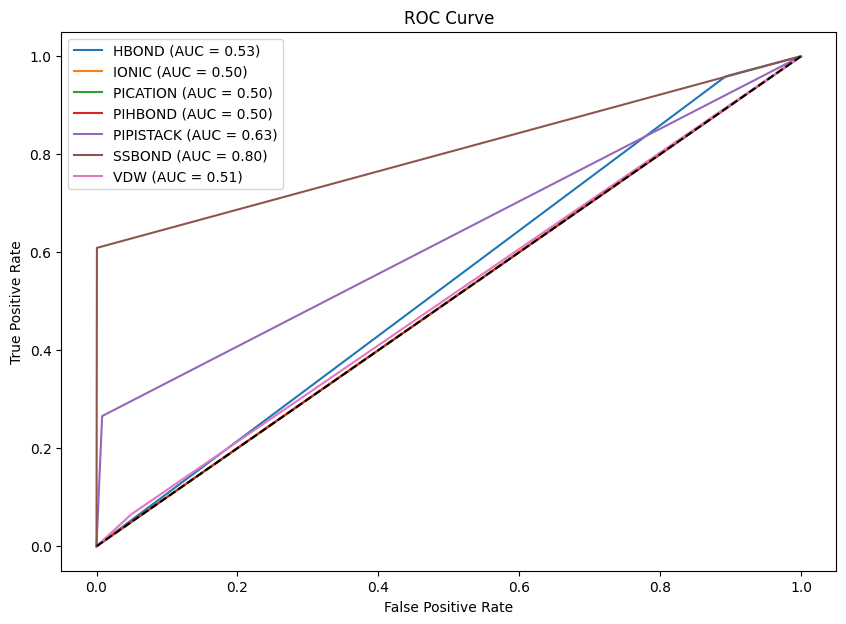

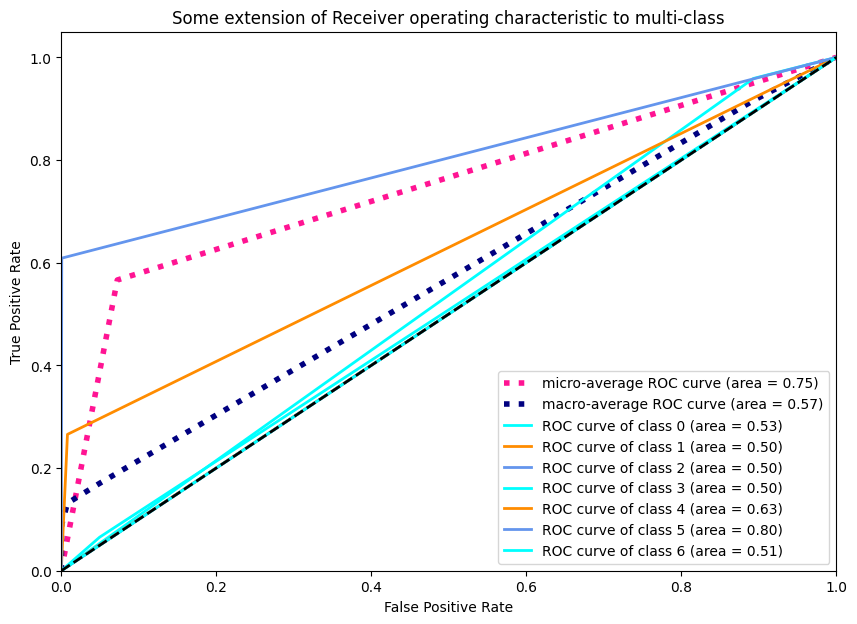

In [24]:
# ROC Curve
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass ROC
y_test_binarized = label_binarize(y_new_test, classes=np.unique(y))
y_pred_binarized = label_binarize(y_new_pred, classes=np.unique(y))

plt.figure(figsize=(10, 7))
for i, label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


# ROC
Micro-average ROC: Aggregates the contributions of all classes to calculate a single ROC curve. It weights the results based on the frequency of the classes and is influenced by the most frequent class.

Macro-average ROC: Calculates a separate ROC curve for each class and then averages them. It treats each class with equal importance, regardless of their frequency, and weights each class equally.

When to use which?
Micro-average ROC: Use this when you want an overall measure of your model's performance that takes class distribution into account. It is suitable for datasets with imbalanced classes.

Macro-average ROC: Use this when you want to evaluate the average performance of your model across all classes without the class distribution affecting the result. It is suitable for datasets with balanced classes or when each class is equally important.